# Conservative Investor

**Task at hand:**</br>

Perform a rolling window simulation on a historical stock price data from Yahoo Finance to recalculate the optimal portfolio at the moment of time, assuming the step of recalculation and window prior to optimization (in trading days).

Notes:</br>
1. The approach described here assumes the conservative type of investor which aims to minimize volatility.</br>
2. The approach does not account for the fees taken by a broker to reallocate investments in each iteration.

In [3]:
# install necessary libs
!pip install yfinance
!pip install PyPortfolioOpt
# load necessary libs
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# import closing price data
assets = ['AAPL','MSFT','AMZN','GOOGL','TSLA','NVDA','META','JPM','UNH',
          'JNJ','PG','V','HD','BAC','XOM']
df = pd.DataFrame()
for i in assets:
 df[i] = yf.download(i,'2015-01-01',end='2022-02-01')['Close']
df.head(5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,AAPL,MSFT,AMZN,GOOGL,TSLA,NVDA,META,JPM,UNH,JNJ,PG,V,HD,BAC,XOM
Date,,,,,,,,,,,,,,,
2015-01-02,27.332500,46.759998,15.4260,26.477501,14.620667,5.0325,78.449997,62.490002,100.779999,104.519997,90.440002,66.254997,103.430000,17.900000,92.830002
2015-01-05,26.562500,46.330002,15.1095,25.973000,14.006000,4.9475,77.190002,60.549999,99.120003,103.790001,90.010002,64.792503,101.260002,17.379999,90.290001
2015-01-06,26.565001,45.650002,14.7645,25.332001,14.085333,4.7975,76.150002,58.980000,98.919998,103.279999,89.599998,64.375000,100.949997,16.860001,89.809998
2015-01-07,26.937500,46.230000,14.9210,25.257500,14.063333,4.7850,76.150002,59.070000,99.930000,105.559998,90.070000,65.237503,104.410004,16.940001,90.720001
2015-01-08,27.972500,47.590000,15.0230,25.345501,14.041333,4.9650,78.180000,60.389999,104.699997,106.389999,91.099998,66.112503,106.720001,17.290001,92.230003


In [5]:
# calculate the percent change each day
returns = df.pct_change()
# add first row filled with ones
returns_with_p = returns.copy()
returns_with_p['portfolio'] = np.zeros(shape=len(returns))
returns_with_p.iloc[0] = np.ones(shape=len(assets)+1)
returns_with_p.head(5)

,AAPL,MSFT,AMZN,GOOGL,TSLA,NVDA,META,JPM,UNH,JNJ,PG,V,HD,BAC,XOM,portfolio
Date,,,,,,,,,,,,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2015-01-05,-0.028172,-0.009196,-0.020517,-0.019054,-0.042041,-0.016890,-0.016061,-0.031045,-0.016471,-0.006984,-0.004755,-0.022074,-0.020980,-0.029050,-0.027362,0.0
2015-01-06,0.000094,-0.014677,-0.022833,-0.024679,0.005664,-0.030318,-0.013473,-0.025929,-0.002018,-0.004914,-0.004555,-0.006444,-0.003061,-0.029919,-0.005316,0.0
2015-01-07,0.014022,0.012705,0.010600,-0.002941,-0.001562,-0.002606,0.000000,0.001526,0.010210,0.022076,0.005246,0.013398,0.034274,0.004745,0.010133,0.0
2015-01-08,0.038422,0.029418,0.006836,0.003484,-0.001564,0.037618,0.026658,0.022346,0.047733,0.007863,0.011436,0.013413,0.022124,0.020661,0.016645,0.0


In [6]:
step = 30

In [7]:
window = 125

In [ ]:
# initialize the weights_rolling dataFrame, used to store multiple sets of optimized weights
weights_rolling = pd.DataFrame()

# set counters for steps (i), index to store weights (ind) and index to update portfolio returns (ind_w)
ind = 1
ind_w = window

# loop through the days of the portfolio, setting window sized steps
while i < len(returns):
    # calculate the average returns for the current window, to be used in the optimization process
    expected_return = returns.iloc[i:i+window,:].mean()

    # calculate the covariance of the returns for the current window, to be used in the optimization process
    covariance = returns.iloc[i:i+window,:].cov()
    
    # initialize the Efficient Frontier optimization with the calculated expected returns and covariances
    ef = EfficientFrontier(expected_return, covariance)
    
    # run the minimum volatility portfolio optimization
    ef.min_volatility()
    
    # reformat the optimization weights into a matrix
    efweights = np.mat(ef.weights)
    
    # store the weights in the weights_rolling dataFrame
    weights_rolling[ind] = pd.DataFrame.from_dict(ef.clean_weights(),orient='index')
    
    # compute the portfolio return for the next step days and store the result in the 'portfolio' column of the returns_with_p DataFrame
    returns_with_p.iloc[ind_w:(ind_w+step),len(assets)] = np.dot(returns_with_p.iloc[ind_w:(ind_w+step),0:len(assets)],efweights.T)
    
    # move forward in time by step
    i += step
    ind += 1
    ind_w += step

# print the last 5 values of the computed portfolio returns 
returns_with_p['portfolio'].tail(5)

In [ ]:
# initialize a plot
fig, ax = plt.subplots(figsize=(16, 6), dpi=200)
# transpose the DataFrame for appropriate orientation
cweights = weights_rolling.T 
# plot the fd as a stacked bar chart for visualizing proportion of each stock in portfolio across iterations
cweights.plot(
    kind = 'bar', 
    stacked = True, 
    title = 'Portfolio Weights Across Iterations (Conservative)',
    mark_right = True, 
    ax=ax
)
# set the x and y labels of the plot
plt.xlabel('Iterations')
plt.ylabel('Weights')
# set the legend location
plt.legend(loc="lower left", bbox_to_anchor=(1, -0.05))
# adjust layout for better visual appeal
plt.tight_layout()
# save the plot in high resolution png image
plt.savefig('Portfolio Weights Across Iterations (Conservative).png', dpi=500)

In [14]:
threshold_pie = 6

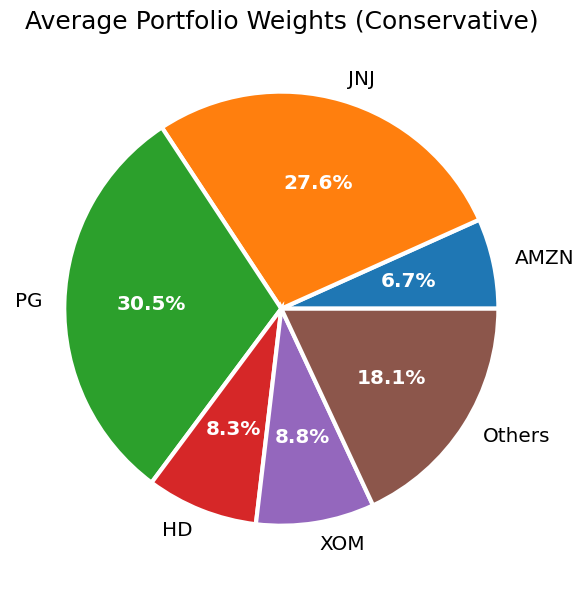

In [25]:
# drop all assets in the weights dataframe where the sum of their weights is less than a specified threshold percentage
avg_weights = cweights.sum()
others = avg_weights.loc[(avg_weights<((avg_weights.sum()/100)*threshold_pie))]
avg_weights = avg_weights.loc[~(avg_weights<((avg_weights.sum()/100)*threshold_pie))]

# combine all dropped weights into a new category named 'Others'
avg_weights['Others'] = others.sum()

# create a pie chart of the average weights of portfolio assets
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
x = avg_weights.values
labels = avg_weights.index.values

# create the pie chart using the weights as x-values and the labels for the asset names
# autopct is used to format the value in each pie slice to 1 decimal place
patches, texts, pcts = ax.pie(
    x, labels=labels, autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.setp(pcts, color='white', fontweight='bold')
ax.set_title('Average Portfolio Weights (Conservative)', fontsize=18)
plt.tight_layout()
plt.savefig('Average Portfolio Weights (Conservative).png', dpi=500)

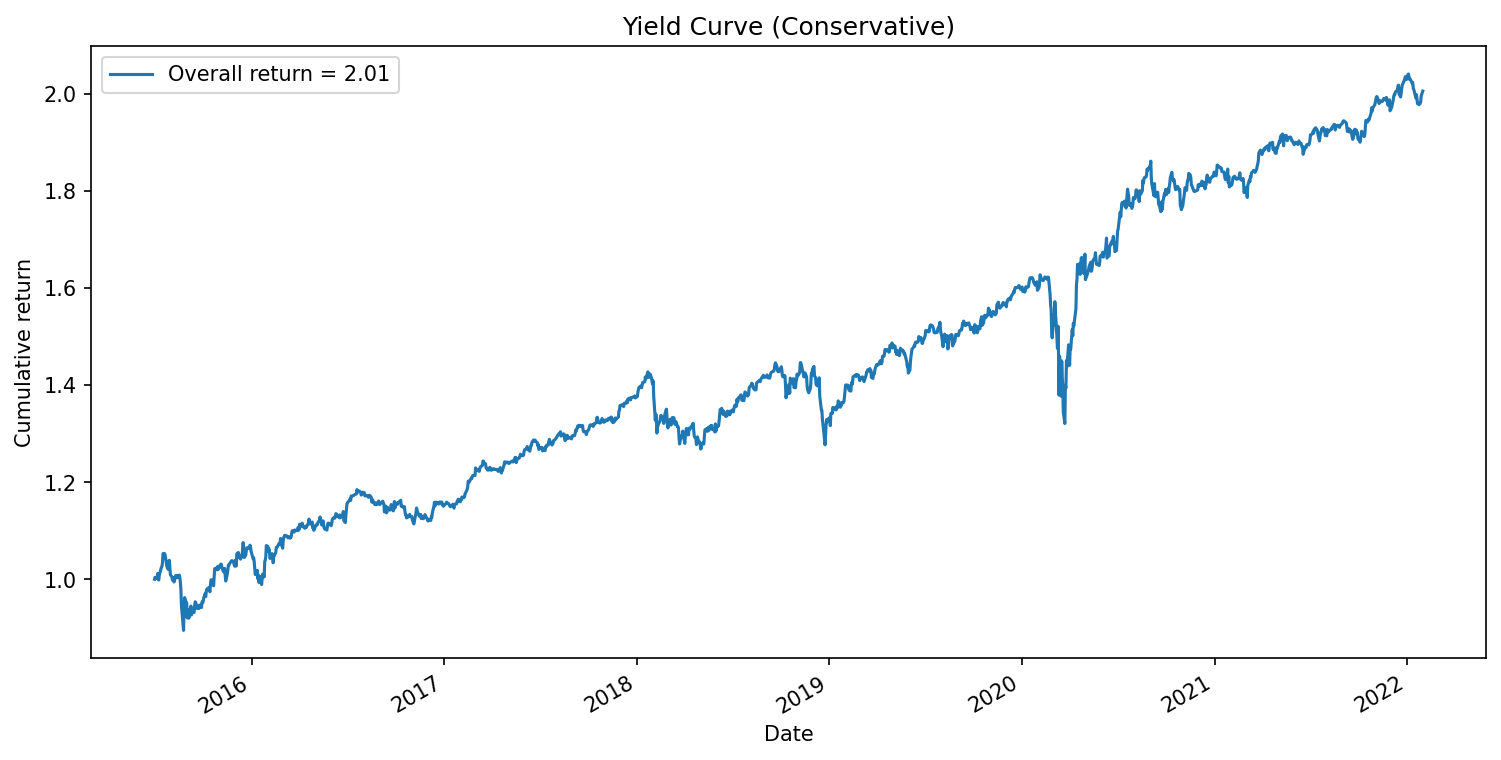

In [20]:
# calculate the yield curve as a cumulative sum of portfolio returns
returns_with_p['yield curve'] = returns_with_p['portfolio'].cumsum()
returns_with_p = returns_with_p.copy().iloc[window-1: , :]

# plot the yield curve
plt.figure(figsize=(12, 6), dpi=150)
returns_with_p['yield curve'].plot(label = 'Overall return = {}'.format(np.round(float(returns_with_p['yield curve'].tail(1)),2)))
plt.title('Yield Curve (Conservative)')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.savefig('Yield Curve (Conservative).png', dpi=500)

In [21]:
risk_free_rate = 0.05

In [22]:
# the portfolio variance is calculated by taking the variance of the portfolio
# returns and scaling it by the total trading days in a year (252)
p_variance = np.var(returns_with_p['portfolio']) * 252

# the portfolio volatility, also known as the standard deviation, is calculated by
# taking the square root of the portfolio variance
p_volatility = np.sqrt(p_variance)

# the average annual return is calculated by taking the mean of the
# portfolio returns and scaling it by the total trading days in a year (252)
p_return = np.mean(returns_with_p['portfolio']) * 252

# the Sharpe ratio is calculated by subtracting the risk-free rate
# from the portfolio return and dividing it by the portfolio volatility
# this gives us a measure of the risk-adjusted return of our portfolio
p_sharpe = (p_return - risk_free_rate) / p_volatility 

# converting the values to percentage format for better readability
percent_vol = str(round((p_volatility * 100), 2)) + '%'
percent_return = str(round((p_return * 100), 2)) + '%'
sharpe_ratio = str(round(p_sharpe, 2))

print('Average annual return: ' + percent_return)
print('Annual volatility: ' + percent_vol)
print('Sharpe ratio: ' + sharpe_ratio)

Average annual return: 15.28%
Annual volatility: 16.8%
Sharpe ratio: 0.61


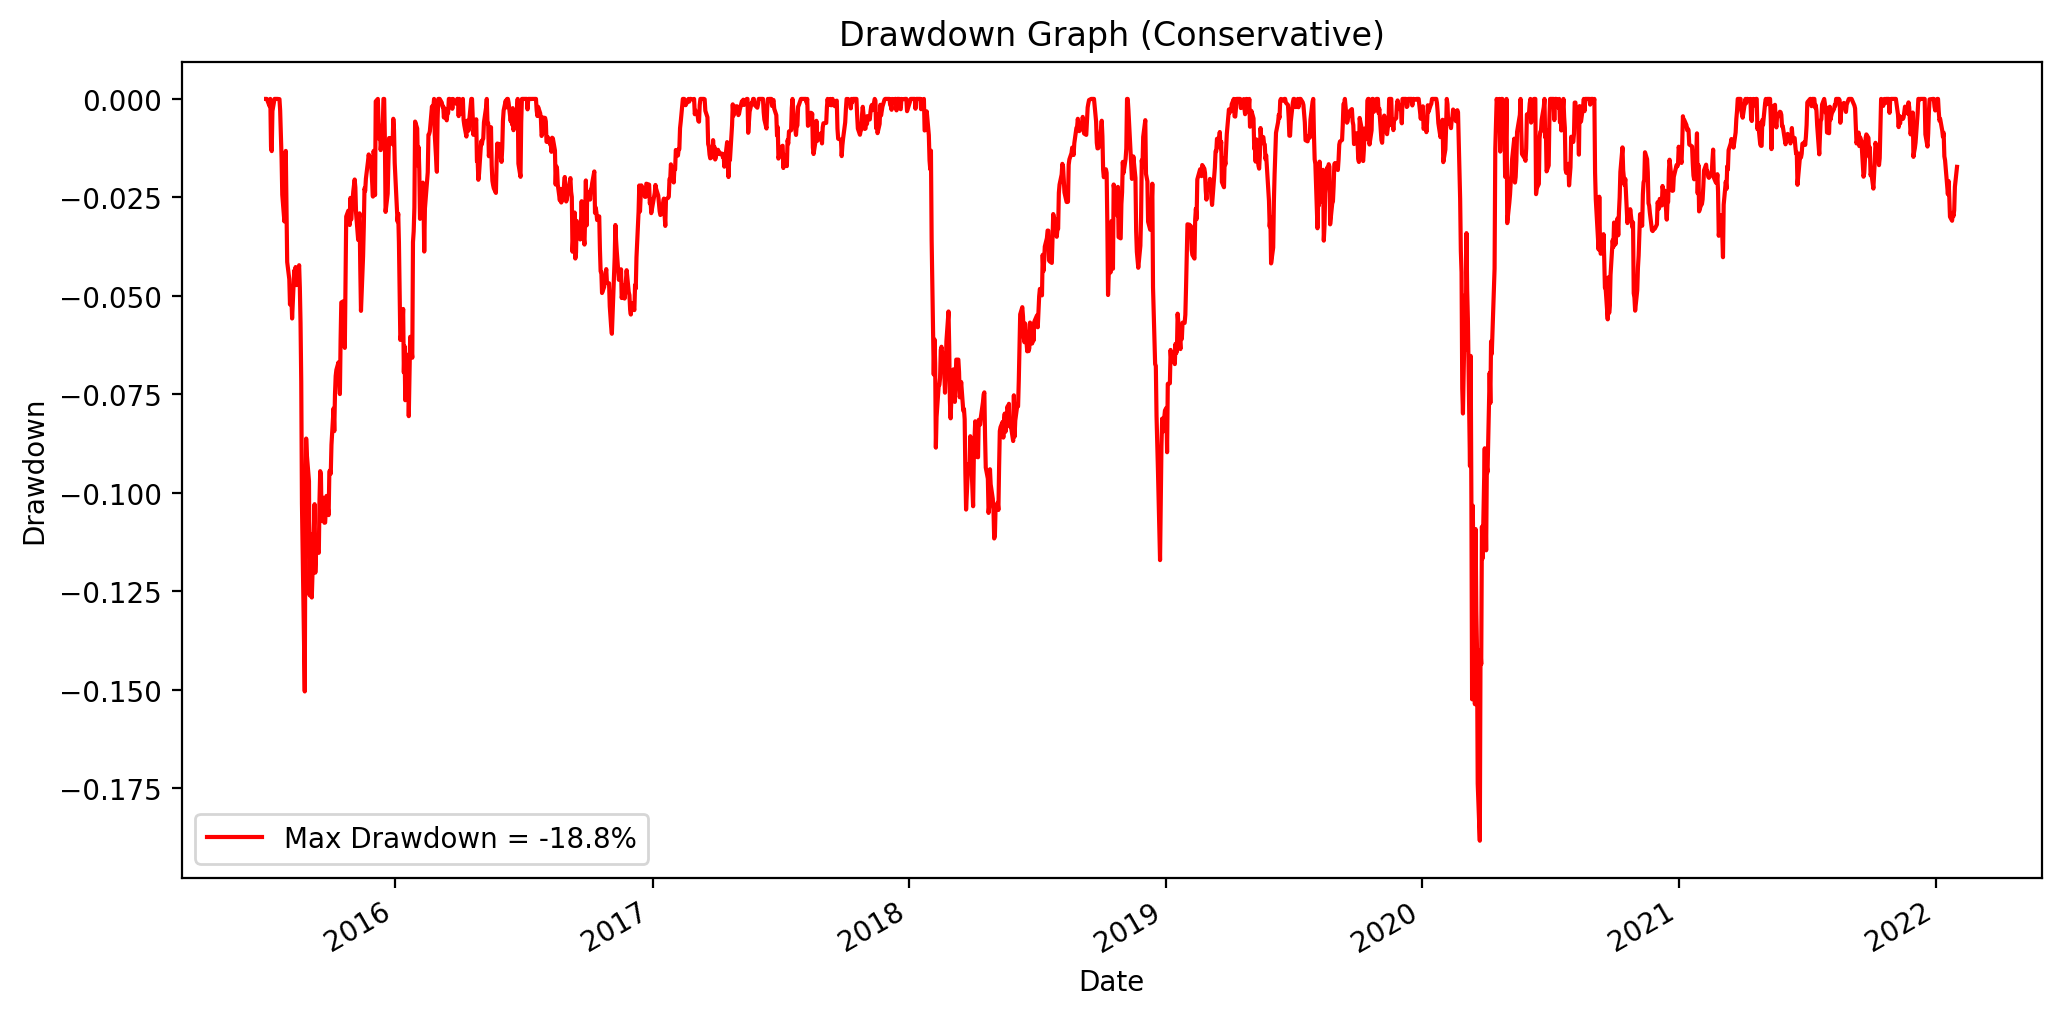

In [23]:

# the drawdown is calculated as the difference between the 'yield curve' and its cumulative maximum
# it represents the loss investor would suffer at a specific point of time
returns_with_p['drawdown'] = returns_with_p['yield curve'] - returns_with_p["yield curve"].cummax()
returns_with_p['drawdown_percent'] = (returns_with_p['yield curve']/returns_with_p["yield curve"].cummax())-1

# plot to show the proportion of drawdown over time
# the label is printed with the minimum value of drawdown
plt.figure(figsize=(12, 6), dpi=200)

returns_with_p['drawdown_percent'].plot(color='red', label='Max Drawdown = {}%'.format(np.round(returns_with_p['drawdown_percent'].min(), 3) * 100))
plt.title('Drawdown Graph (Conservative)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.savefig('Drawdown graph (Conservative).png', dpi=500)

In [24]:
# initializing a counter variable to count the number of consecutive days in drawdown
count = 0
# initializing the variable that will store the longest streak of days in drawdown found so far
prev = 0
# initializing the variable that will store the index of the end of the longest streak of days in drawdown
indexend = 0 
# looping over each day in the portfolio
for i in range(0,len(returns_with_p['drawdown'])):
    # if there is a drawdown on this day
    if returns_with_p['drawdown'][i] < 0:
        # increment the counter
        count += 1
    else: 
        # if there is no drawdown on this day, this means the previous streak has ended         
        # if the length of this streak is greater than the longest found so far
        if count > prev:
            # update longest streak of drawdown days and the end index  
            prev = count
            indexend = i
        # reset the count for tracking new drawdown streak.
        count = 0
# printing the longest recovery period in trading days
print("The longest recovery period is "+str(prev)+" trading days ")

The longest recovery period is 164 trading days 
